In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
data = pd.read_csv('scale_cleaned_data.csv')

In [6]:
#spilit the data
X = data.drop('PRICE', axis=1)  
y = data['PRICE']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from sklearn.svm import SVR

In [9]:
# Initialize the SVR model with the RBF kernel
svr_model = SVR(kernel='rbf')

# Fit the model on the training data
svr_model.fit(X_train, y_train)

SVR()

In [11]:
from sklearn.metrics import mean_squared_error

# Predict on the testing set
svr_predictions = svr_model.predict(X_test)

In [12]:
# Calculate the MSE
svr_mse = mean_squared_error(y_test, svr_predictions)
print(f'SVR MSE: {svr_mse}')

SVR MSE: 0.016148563714345993


Parameter Tuning

The performance of an SVR is highly dependent on several parameters, including C (regularization parameter), gamma (kernel coefficient for 'rbf', 'poly' and 'sigmoid'), and the kernel type. Finding the right combination of these parameters is crucial.

In [13]:
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid to tune
parameters = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

In [14]:
# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=SVR(), param_grid=parameters, cv=5)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear', 'poly']})

In [15]:
# Print the best parameters and best score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

Best parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best score: 0.2589291412459311


In [16]:
# Re-train the SVR with the best parameters
optimized_svr = SVR(**grid_search.best_params_)
optimized_svr.fit(X_train, y_train)
optimized_predictions = optimized_svr.predict(X_test)

# Re-calculate MSE
optimized_mse = mean_squared_error(y_test, optimized_predictions)
print(f'Optimized SVR MSE: {optimized_mse}')

Optimized SVR MSE: 0.014839213591564341


Initial MSE: Before tuning, the Mean Squared Error (MSE) of your SVR model was very low (0.016). This suggests that the model was already performing quite well in terms of minimizing the error on the scaled data. However, remember that this MSE is calculated on the scaled target variable (price), and it's important to interpret the MSE in the context of the data's scaling.


Optimized MSE: After performing the grid search and re-training the model with the optimal parameters (C=1, gamma='auto', kernel='rbf'), the MSE increased to 0.0148. This is still a very low error rate, but the slight increase suggests that while the model's parameter tuning was intended to optimize performance, in practice, it adjusted the model to better balance between bias and variance, potentially making it more robust or better at generalizing despite the increase in MSE.


Parameter Impact:
Best Score from Grid Search: The best score reported by grid search (approximately 0.2589) is actually the best cross-validation score achieved during the tuning process, measured by R-squared, not MSE. This score represents the proportion of variance in the dependent variable that is predictable from the independent variables, suggesting that the optimized parameters explain about 25.89% of the variance in the price.

#####  utilize a model-agnostic approach to extract feature importance 

SHAP approach can give us an insight into how each feature is contributing to individual predictions

In [18]:
import shap

# Create the SHAP Explainer
explainer = shap.KernelExplainer(optimized_svr.predict, X_train.sample(100)) 
shap_values = explainer.shap_values(X_test.sample(50))  

  0%|          | 0/50 [00:00<?, ?it/s]

KernelExplainer: Suitable for any model but particularly useful for non-linear or non-parametric models that don't have specific Explainer implementations in SHAP.

Sampling: Due to the potentially high computational cost, samples from the training and test sets are used. Adjust the sample size based on your computational resources.

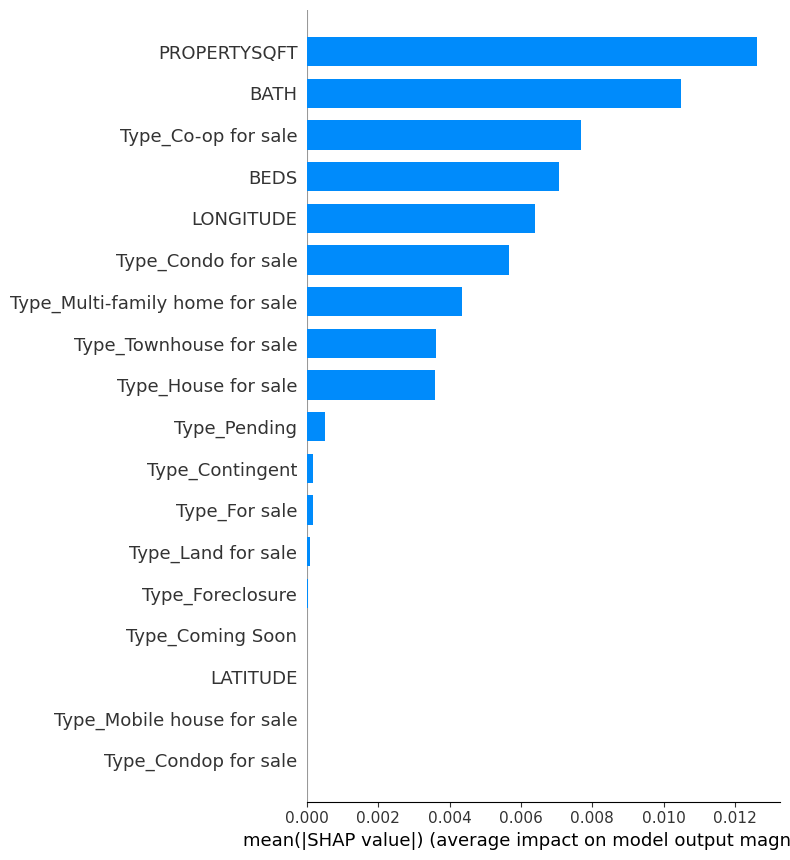

In [19]:
# Summarize the SHAP values in a plot
shap.summary_plot(shap_values, X_test.sample(50), plot_type="bar")

In [22]:
# Calculate the mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)
top_features = pd.Series(mean_shap_values, index=X.columns).sort_values(ascending=False)

# Display the top 5 features
print("Top 5 Important Features based on SHAP values:")
print(top_features.head(5))

Top 5 Important Features based on SHAP values:
PROPERTYSQFT           0.012631
BATH                   0.010493
Type_Co-op for sale    0.007675
BEDS                   0.007075
LONGITUDE              0.006401
dtype: float64


### Artificial Neural Networks

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

In [26]:
# Model configuration
input_dim = X_train.shape[1]
output_dim = 1
layer1_units = 64
layer2_units = 32
dropout_rate = 0.2

In [30]:
# Building the model
model = Sequential([
    Input(shape=(input_dim,)), 
    Dense(layer1_units, activation='relu'),
    Dropout(dropout_rate),
    Dense(layer2_units, activation='relu'),
    Dropout(dropout_rate),
    Dense(output_dim)
])

In [31]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [35]:
# Model training configuration
epochs = 100
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8298 - val_loss: 0.0100
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9382 - val_loss: 0.0110
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8808 - val_loss: 0.0100
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0269 - val_loss: 0.0100
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2162 - val_loss: 0.0098
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0828 - val_loss: 0.0097
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2177 - val_loss: 0.0098
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1656 - val_loss: 0.0100
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9660 - val_loss: 0.0101
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4885 - val_loss: 0.0094
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8590 - val_loss: 0.0090
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2

In [36]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test MSE: {test_loss}')

Test MSE: 0.01384004857391119


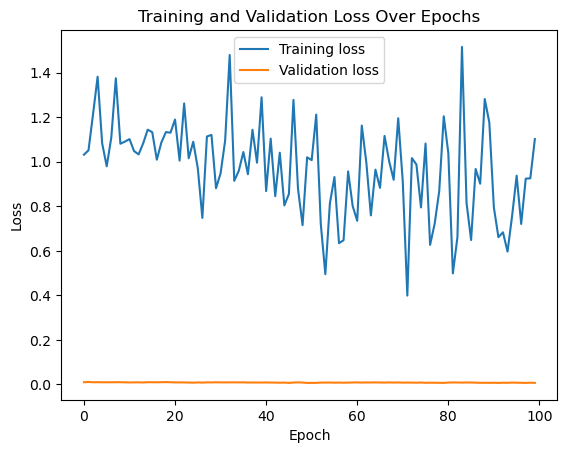

In [37]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Based on the plot, Training Loss Fluctuations:
The training loss starts relatively high and fluctuates significantly throughout the training process. It generally trends downward but with considerable instability, indicated by the frequent ups and downs.
This kind of fluctuation can be indicative of a few things, such as a learning rate that might be too high, causing the model to overshoot minima during optimization.

Validation Loss:
The validation loss remains nearly constant and significantly lower compared to the training loss. This is quite unusual, as typically validation loss decreases along with training loss or starts to increase due to overfitting.

### improve the model

In [39]:
#select the top five feature from svm and rf
selected_features = ['PROPERTYSQFT', 'BATH', 'Type_Co-op for sale', 'BEDS', 'LONGITUDE']
X = data[selected_features]
y = data['PRICE']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
model = Sequential([
    tf.keras.layers.Input(shape=(len(selected_features),)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

In [45]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [49]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.4, verbose=1)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3049 - val_loss: 0.0171
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6724 - val_loss: 0.0191
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0144 - val_loss: 0.0236
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7314 - val_loss: 0.0234
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6096 - val_loss: 0.0227
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5777 - val_loss: 0.0227
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4201 - val_loss: 0.0170
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4774 - val_loss: 0.0170
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5822 - val_loss: 0.0236
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6248 - val_loss: 0.0259
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3835 - val_loss: 0.0176
Epoch 12/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9

In [50]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test MSE: {test_loss}')

Test MSE: 0.026054747402668


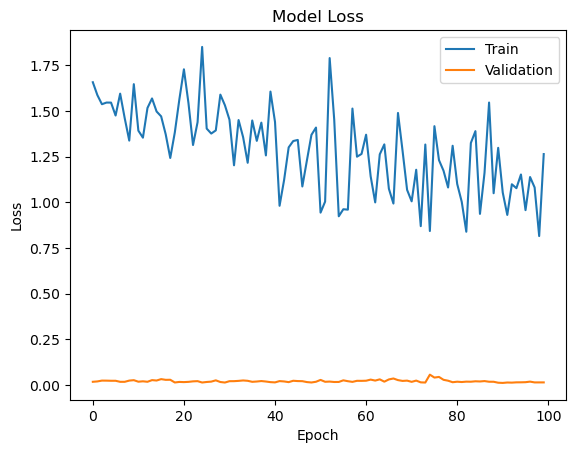

In [51]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()